# Answering Business Questions using SQL

The goal of this project is to gain hands-on experience using SQLite and Python to extract, analyze, and create visualizations from data within the Chinook database in order to answer multiple business questions.  

In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        query_result = pd.read_sql(query, conn)
        return query_result

def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)
        
def show_tables():
    query = '''
    SELECT
        name, type
    FROM sqlite_master
    WHERE type IN ("table", "view");'''
    return run_query(query)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
query = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) * 100 percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''


run_query(query)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


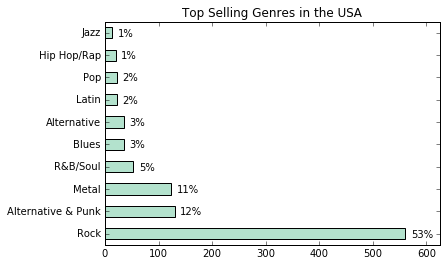

In [29]:
genre_sales_usa = run_query(query)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Pastel2
)

plt.ylabel('')

for i, genre in enumerate(list(genre_sales_usa.index)):
    tracks_sold = genre_sales_usa.loc[genre, "tracks_sold"]
    label = (genre_sales_usa.loc[genre, "percentage_sold"]
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (tracks_sold + 10, i - 0.15))

plt.show()

Based on the results of the query, the albums from Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop) should be added to the store.

In [36]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY i.customer_id, c.support_rep_id
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY employee;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


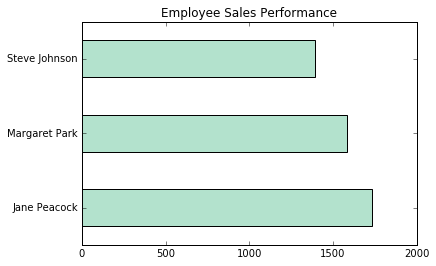

In [38]:
esp = run_query(employee_sales_performance)
esp.set_index("employee", inplace=True, drop=True)

esp["total_sales"].plot.barh(
    title="Employee Sales Performance",
    xlim=(0, 2000),
    colormap=plt.cm.Pastel2
)

plt.ylabel('')

plt.show()

At first glance, there is a relatively large gap between the employee with the most sales and the employee with the least sales, but that is most likely due to their hire dates. 

In [39]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


It seems like Canada, France, and the United Kingdom have potential for growth, as their lifetime values are the lowest. 

In [40]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


The Chinook store should continue to buy full albums from record companies, because they make up 18.56% of revenue.